# 深層学習スクラッチ　ニューラルネットワーク

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
from collections import defaultdict

In [3]:
import os

In [5]:
conda list

# packages in environment at /Users/shinoda/.pyenv/versions/anaconda3-2019.10:
#
# Name                    Version                   Build  Channel
_py-xgboost-mutex         2.0                       cpu_0  
absl-py                   0.9.0                    pypi_0    pypi
anaconda-client           1.7.2                    py37_0  
anaconda-navigator        1.9.7                    py37_0  
appnope                   0.1.0                    py37_0  
asn1crypto                1.3.0                    py37_0  
astor                     0.8.1                    pypi_0    pypi
astunparse                1.6.3                    pypi_0    pypi
attrs                     19.3.0                     py_0  
autopep8                  1.5                      pypi_0    pypi
backcall                  0.1.0                    py37_0  
backports                 1.0                        py_2  
backports.functools_lru_cache 1.6.1                      py_0  
backports.tempfile        1.0               

In [4]:
pip list

Package                           Version            
--------------------------------- -------------------
absl-py                           0.9.0              
anaconda-client                   1.7.2              
anaconda-navigator                1.9.7              
appnope                           0.1.0              
asn1crypto                        1.3.0              
astor                             0.8.1              
astunparse                        1.6.3              
attrs                             19.3.0             
autopep8                          1.5                
backcall                          0.1.0              
backports.functools-lru-cache     1.6.1              
backports.tempfile                1.0                
backports.weakref                 1.0.post1          
beautifulsoup4                    4.8.2              
bleach                            3.1.0              
blis                              0.4.1              
bokeh                       

In [2]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [9]:
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [10]:
print(X_train.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(X_train[0].dtype) # uint8
print(X_train[0])

(60000, 28, 28)
(10000, 28, 28)
uint8
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0 

In [11]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

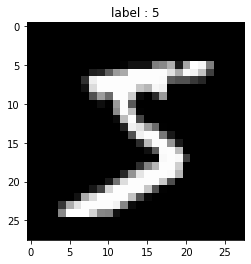

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray', vmin = 0, vmax = 255)
plt.title('label : {}'.format(y_train[index]))
plt.show()

In [13]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


また、正解ラベルは0から9の整数ですが、ニューラルネットワークで多クラス分類を行う際には one-hot表現 に変換します。scikit-learnのOneHotEncoderを使用したコードが以下です。このone-hot表現による値はそのラベルである確率を示していることになるため、float型で扱います。

In [14]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


らに、訓練データ6万枚の内2割を検証データとして分割してください。訓練データが48000枚、検証データが12000枚となります。

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

(48000, 784)
(12000, 784)


# ミニバッチ処理

これまでの機械学習スクラッチでは、全てのサンプルを一度に計算していました。しかし、ニューラルネットワークではデータを分割して入力する 確率的勾配降下法 が一般的です。分割した際のひとかたまりを ミニバッチ 、そのサンプル数を バッチサイズ と呼びます。


今回はバッチサイズを20とします。今回使う訓練データは48000枚ですから、48000÷20で2400回の更新を繰り返すことになります。ニューラルネットワークではこれを2400回 イテレーション（iteration） すると呼びます。訓練データを一度全て見ると1回の エポック（epoch） が終わったことになります。このエポックを複数回繰り返し、学習が完了します。


これを実現するための簡素なイテレータを用意しました。for文で呼び出すと、ミニバッチを取得できます。

In [10]:
get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=20)
print(len(get_mini_batch)) # 2400
print(get_mini_batch[5]) # 5番目のミニバッチが取得できる
for mini_X_train, mini_y_train in get_mini_batch:
    # このfor文内でミニバッチが使える
    pass

2400
(array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0

# 【問題1】重みの初期値を決めるコードの作成

ニューラルネットワークの各層の重みの初期値を決めるコードを作成してください。


重みの初期値は様々な方法が提案されていますが、今回はガウス分布による単純な初期化を行います。バイアスに関しても同様です。


以下のコードを参考にしてください。標準偏差の値sigmaはハイパーパラメータです。発展的な重みの初期化方法については次のSprintで扱います。

In [11]:
n_features = 784
n_nodes1 = 400
sigma = 0.01 # ガウス分布の標準偏差
W1 = sigma * np.random.randn(n_features, n_nodes1)
# W1: (784, 400)

# 【問題2】フォワードプロパゲーションの実装

三層のニューラルネットワークの フォワードプロパゲーション を作成してください。以下の説明ではノード数は1層目は400、2層目は200としますが、変更しても構いません。


各層の数式を以下に示します。今回はそれぞれの記号が表す配列が、実装上どのようなndarrayのshapeになるかを併記してあります。

In [12]:
batch_size = 20 # バッチサイズ
n_features = 784 # 特徴量の数
n_nodes1 = 400 # 1層目のノード数
n_nodes2 = 200 # 2層目のノード数
n_output = 10 # 出力のクラス数（3層目のノード数）

活性化関数（フォワードプロバゲーション）「シグモイド関数」

$
f(Z) = sigmoid(A) = \frac{1}{1+exp(-A)}
$

指数関数 
e
x
p
(
−
A
)
 の計算はnp.expを使用してください。

In [13]:
def sigmoid(A):
    return (1/(1 + np.exp(-A)))

In [51]:
def tanh(A):
    return (np.exp(A) - np.exp(-A))/(np.exp(A) + np.exp(-A))

「1層目」

$
A_1 = X \cdot W_1 + B_1
$

In [14]:
sigma = 0.01 # ガウス分布の標準偏差
B1 = sigma * np.random.randn(n_nodes1,)


In [15]:
B1.shape

(400,)

In [16]:
A1 = np.dot(mini_X_train, W1) + B1

In [17]:
A1.shape

(20, 400)

「1層目の活性化関数」

$
Z_1 = f(A_1)
$

Z
1
 出力 (batch_size, n_nodes1)

In [52]:
Z1 = tanh(A1)
Z1.shape

(20, 400)

「2層目」

$
A_2 = Z_1 \cdot W_2 + B_2
$

In [53]:
n_features = 784
n_nodes2 = 200
sigma = 0.01 # ガウス分布の標準偏差
W2 = sigma * np.random.randn(n_nodes1, n_nodes2)
W2.shape

(400, 200)

In [54]:
n_features = 784
n_nodes2 = 200
sigma = 0.01 # ガウス分布の標準偏差
B2 = sigma * np.random.randn(n_nodes2, )
B2.shape

(200,)

In [55]:
A2 = np.dot(Z1, W2) + B2
A2.shape

(20, 200)

「2層目の活性化関数」

$
Z_2 = f(A_2)
$

In [56]:
Z2 = tanh(A2)
Z2.shape

(20, 200)

「3層目（出力層）」

$
A_3 = Z_2 \cdot W_3 + B_3
$

In [57]:
n_features = 784
n_nodes2 = 200
sigma = 0.01 # ガウス分布の標準偏差
W3 = sigma * np.random.randn(n_nodes2, n_output)
W3.shape

(200, 10)

In [58]:
sigma = 0.01 # ガウス分布の標準偏差
B3 = sigma * np.random.randn(n_output, )
B3.shape

(10,)

In [59]:
A3 = np.dot(Z2, W3) + B3
A3.shape

(20, 10)

「3層目の活性化関数」

$
Z_3 = softmax(A_3)
$

ソフトマックス関数

ソフトマックス関数を作成し、フォワードプロパゲーションの中で使用します。これも活性化関数の一種ですが、多クラス分類の出力層で使われる特性上、区別して扱われることが多いです。


次の数式です。



$
Z_{3\_k} = \frac{exp(A_{3\_k})}{\sum_{i=1}^{n_c}exp(A_{3\_i})}
$

    Z
3
k
 : 
k
 番目のクラスの確率ベクトル (batch_size,)


A
3
k
 : 
k
 番目のクラスにあたる前の層からのベクトル (batch_size,)


n
c
 : クラスの数、n_output。今回のMNISTでは10。

分母は全てのクラスに相当する値を指数関数に通した上で足し合わせたものです。その中で、分子に 
k
 番目のクラスを持ってくることで、 
k
 番目のクラスである確率が求まります。


これを10クラス分計算し、合わせたものが 
Z
3
 です。

In [60]:
A3.shape

(20, 10)

In [61]:
A3

array([[ 9.20757361e-03, -7.68499990e-03, -1.76746788e-02,
         1.09187818e-03,  1.01979992e-02,  4.61024791e-03,
         3.80528861e-03,  1.98473499e-02,  2.64492225e-03,
         4.09917908e-03],
       [ 9.41802752e-03, -5.34069227e-03, -1.81975879e-02,
         2.67270849e-03,  1.11804058e-02,  5.40143451e-03,
         3.97813208e-03,  1.79165956e-02,  7.84953549e-03,
         5.53745371e-03],
       [ 1.04636774e-02, -5.30418326e-03, -2.02910461e-02,
        -5.09355427e-04,  7.11006130e-03,  4.99718006e-03,
         1.27556680e-03,  2.02193949e-02,  1.02654149e-02,
         1.67551694e-03],
       [ 8.29417279e-03, -8.46647576e-03, -1.99729178e-02,
        -1.63905901e-03,  1.24553429e-02,  2.99084808e-03,
         3.71518082e-03,  1.82567043e-02,  5.05647571e-03,
         1.03562641e-03],
       [ 8.37030807e-03, -5.62310422e-03, -1.60195282e-02,
         5.39794957e-03,  1.43392372e-02,  4.44781650e-03,
         3.01445624e-03,  1.88483082e-02,  5.36161443e-03,
         5.

In [62]:
A3[0,1]

-0.007684999898484143

In [63]:
np.exp(A3[:, 6])

array([1.00381254, 1.00398606, 1.00127638, 1.00372209, 1.003019  ,
       1.00221151, 0.99777879, 1.0015205 , 1.00294155, 1.00303915,
       1.00415673, 1.00098081, 1.00193625, 1.00353691, 1.00008553,
       1.00227   , 0.9989041 , 1.00351216, 1.00335572, 1.00077514])

In [64]:
np.sum(np.exp(A3), axis = 1)

array([10.03065286, 10.04093587, 10.03047454, 10.0222659 , 10.04438809,
       10.02689742, 10.03157163, 10.03122691, 10.03380384, 10.03256543,
       10.02703638, 10.03921183, 10.04432849, 10.03236849, 10.03620165,
       10.02652318, 10.04493615, 10.04418533, 10.03446156, 10.03750268])

In [65]:
def softmax(A3):
    A3 = A3.T
    ue = np.exp(A3)
    #print(ue.shape)
    shita = np.sum(np.exp(A3), axis = 0)
    #print(shita)
    return (ue/shita).T

In [66]:
final_answer = softmax(A3)

In [67]:
final_answer.shape

(20, 10)

In [68]:
np.sum(final_answer, axis = 1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [69]:
def softmax2(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T
    x = x - np.max(x)   # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x))

In [70]:
final_answer2 = softmax2(A3)
final_answer2.shape

(20, 10)

In [71]:
np.sum(final_answer2, axis = 1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

# 【問題3】交差エントロピー誤差の実装

目的関数（損失関数）を作成します。


多クラス分類の目的関数である交差エントロピー誤差 
L
 は次の数式です。
 

$
L = - \frac{1}{n_b}\sum_{j}^{n_b}\sum_{k}^{n_c}y_{jk} log(z_{3\_jk})
$

y
i
j
 : 
j
 番目のサンプルの 
k
 番目のクラスの正解ラベル（one-hot表現で0か1のスカラー）


z
3
i
j
 : 
j
 番目のサンプルの 
k
 番目のクラスの確率（スカラー）


n
b
 : バッチサイズ、batch_size


n
c
 : クラスの数、n_output（今回のMNISTでは10）


サンプル1つあたりの誤差が求まります。



In [45]:
def crossentropy(final_answer, mini_y_train):
    return -np.sum(mini_y_train * np.log(final_answer))/(final_answer.shape[0])

In [46]:
crossentropy(final_answer, mini_y_train)

2.2944602794813678

In [50]:
qq = np.exp(-7)
qq

0.0009118819655545162

In [ ]:
get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=20)
print(len(get_mini_batch)) # 2400
#print(get_mini_batch[5]) # 5番目のミニバッチが取得できる
for mini_X_train, mini_y_train in get_mini_batch:
    # このfor文内でミニバッチが使える
    y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
    
    
    
    pass

In [ ]:
#y_train_one_hot.shape

# 【問題4】バックプロパゲーションの実装

In [98]:
delta1 = final_answer - mini_y_train
delta2 = (1 - np.tanh(A2)**2) * (np.dot(delta1,W3.T))
delta3 = (1 - np.tanh(A1)**2) * (np.dot(delta2,W2.T))

In [105]:
#layer3
b3grad = delta1
W3grad = np.dot(Z2.T,delta1)
#layer2
b2grad = delta2
W2grad = np.dot(Z1.T,delta2)
#layer1
b1grad = delta1
W1grad =np.dot(mini_X_train.T,delta3)
W1grad.shape

(784, 400)

# 【問題5】推定

推定を行うメソッドを作成してください。


フォワードプロパゲーションによって出力された10個の確率の中で、最も高いものはどれかを判定します。

In [26]:
class ScratchSimpleNeuralNetrowkClassifier():
    """
    シンプルな三層ニューラルネットワーク分類器

    Parameters
    ----------

    Attributes
    ----------
    """
    def __init__(self, verbose = True):
        
        self.n_nodes1 = 400 # 1層目のノード数
        self.n_nodes2 = 200 # 2層目のノード数
        self.n_output = 10 # 出力のクラス数（3層目のノード数）
        self.sigma = 0.01 # ガウス分布の標準偏差
        
        
        
        
        self.verbose = verbose
        pass
    def fit(self, X, y, X_val=None, y_val=None, val=False):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        
        self.W1 = self.sigma * np.random.randn(X.shape[1], self.n_nodes1)
        self.B1 = self.sigma * np.random.randn(self.n_nodes1,)
        self.W2 = self.sigma * np.random.randn(self.n_nodes1, self.n_nodes2)
        self.B2 = self.sigma * np.random.randn(self.n_nodes2, )
        self.W3 = self.sigma * np.random.randn(self.n_nodes2, self.n_output)
        self.B3 = self.sigma * np.random.randn(self.n_output, )
        
       
        
        
        #エポック毎の損失を記録
        self.cost = [] 
        self.cost_val = []
        
        self.epoch=1 #何回回すか
        self.alpha = 0.001#学習率
        
        self.hako = []
        self.count = []
        
        #全データ１回分の処理
        for i in range(self.epoch):
            get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=20)
           
                
                
            #バッチ毎の処理

            for mini_X_train, mini_y_train in get_mini_batch:#2400回
                
                print(mini_X_train.shape)
                #フォアード
                A1 = np.dot(mini_X_train, self.W1) + self.B1
                Z1 = self.tanh(A1)
                A2 = np.dot(Z1, self.W2) + self.B2
                Z2 = self.tanh(A2)
                A3 = np.dot(Z2, self.W3) + self.B3
                final_answer = self.softmax(A3)
                #バックプロパゲーション
                delta1 = final_answer - mini_y_train
                delta2 = (1 - np.tanh(A2)**2) * (np.dot(delta1,self.W3.T))###(np.dot(delta1,self.W3.T)) = dz
                delta3 = (1 - np.tanh(A1)**2) * (np.dot(delta2,self.W2.T))
                #print(delta3.shape)
                #layer3
                b3grad = delta1
                W3grad = np.dot(Z2.T,delta1)
                #layer2
                b2grad = delta2
                W2grad = np.dot(Z1.T,delta2)
                #layer1
                b1grad = delta3
                W1grad =np.dot(mini_X_train.T,delta3)
                W1grad.shape
                #更新
#                 print(np.mean(b3grad,axis=0).shape)
#                 print(self.B3.shape)
                self.B3 -= self.alpha*np.mean(b3grad,axis=0)
                self.W3 -= self.alpha*W3grad
#                 print(np.mean(b2grad,axis=0).shape)
#                 print(self.B2.shape)
                self.B2 -= self.alpha*np.mean(b2grad,axis=0)
                self.W2 -= self.alpha*W2grad
#                 print(np.mean(b1grad,axis=0).shape)
#                 print(self.B1.shape)
                self.B1 -= self.alpha*np.mean(b1grad,axis=0)
                self.W1 -= self.alpha*W1grad
            
       #フォアード
            A1 = np.dot(X_train, self.W1) + self.B1
            Z1 = self.tanh(A1)
            A2 = np.dot(Z1, self.W2) + self.B2
            Z2 = self.tanh(A2)
            A3 = np.dot(Z2, self.W3) + self.B3
            final_answer = self.softmax(A3)     

                
            self.cost.append(crossentropy(final_answer, y_train))
            
            
            if val:
                A1 = np.dot(X_val, self.W1) + self.B1
                Z1 = self.tanh(A1)
                A2 = np.dot(Z1, self.W2) + self.B2
                Z2 = self.tanh(A2)
                A3 = np.dot(Z2, self.W3) + self.B3
                final_val_answer = self.softmax(A3)  
                
                self.cost_val.append(crossentropy(final_val_answer, y_val))
                
                
                
        if self.verbose:
            #verboseをTrueにした際は学習過程などを出力する
            print()
        pass
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        A1 = np.dot(X, self.W1) + self.B1
        Z1 = self.tanh(A1)
        A2 = np.dot(Z1, self.W2) + self.B2
        Z2 = self.tanh(A2)
        A3 = np.dot(Z2, self.W3) + self.B3
        pre_final_answer = self.softmax(A3)
        pre_final_answer_answer = np.argmax(pre_final_answer, axis=1)
        return pre_final_answer_answer
    
    def tanh(self, A):
        return (np.exp(A) - np.exp(-A))/(np.exp(A) + np.exp(-A))
    
    def softmax(self, A3):
        A3 = A3.T
        ue = np.exp(A3)
        shita = np.sum(np.exp(A3), axis = 0)
        return (ue/shita).T
    
    def crossentropy(self, final_answer, mini_y_train):
        print(mini_y_train.shape)
        print(final_answer.shape)
        return -np.sum(mini_y_train * np.log(final_answer))/(final_answer.shape[0])
    
        return


In [27]:
ssn = ScratchSimpleNeuralNetrowkClassifier()

In [28]:
ssn.fit(X_train,y_train)

(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)
(20, 784)


NameError: name 'crossentropy' is not defined

In [256]:
pre = ssn.predict(X_val)
pre.shape

(12000,)

# 【問題6】学習と推定

MNISTのデータを学習・推定し、Accuracyを計算してください。

In [235]:
m = np.zeros((12000,10),dtype=int)

In [236]:
(pre)

array([7, 2, 0, ..., 5, 4, 9])

In [237]:
l = 1

In [238]:
pre[l]

2

In [239]:
for h in range(len(pre)):
    m[h,pre[h]] = 1

In [240]:
print(m)

[[0 0 0 ... 1 0 0]
 [0 0 1 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]


In [ ]:
#############################ここから############################

In [244]:
from sklearn.metrics import accuracy_score

In [257]:
predict_box = np.zeros((len(pre),10),dtype=int)
predict_box.shape

(12000, 10)

In [258]:
for v in range(len(pre)):
    predict_box[v,pre[v]] = 1

In [259]:
predict_box

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [260]:
###Accuracy###
accuracy_score(y_val, predict_box)

0.9353333333333333

# 【問題7】学習曲線のプロット

学習曲線をプロットしてください。
ニューラルネットワークは過学習が発生しやすいため、学習曲線の確認が重要です。訓練データと検証データに対するエポックごとの損失（交差エントロピー誤差）を記録できるようにする必要があります。

In [328]:
ssn_val = ScratchSimpleNeuralNetrowkClassifier()

In [329]:
ssn_val.fit(X_train,y_train,X_val,y_val, val = True)

In [330]:
###訓練データに対するエポックごとの損失（交差エントロピー誤差）###
ssn_val.cost

[0.4179527507749753,
 0.32098261037605946,
 0.27479062442660357,
 0.23749005249508054,
 0.2058817580989493,
 0.17944315189897794,
 0.15812898643012666,
 0.140875846265015,
 0.12657976010178637,
 0.1145165172866487,
 0.1042171779306921,
 0.09531204050709119,
 0.08749591357821218,
 0.08054429081901121,
 0.07430452229763297,
 0.0686675621121583,
 0.06354850913247061,
 0.058877832204097244,
 0.05459765932682085,
 0.05065851287214769]

In [331]:
###検証データに対するエポックごとの損失（交差エントロピー誤差）###
ssn_val.cost_val

[0.41707825838599494,
 0.32599378749673763,
 0.2848908854471803,
 0.2522735719211042,
 0.2247532178929386,
 0.20175108602855357,
 0.183239438037834,
 0.16832456517811042,
 0.15607620259035287,
 0.14589167969725303,
 0.13739402676007398,
 0.13027634117020664,
 0.12425921574432025,
 0.1191262376873051,
 0.11472940019479955,
 0.11096081808354366,
 0.10773219914587252,
 0.10496530160443811,
 0.10258688484951824,
 0.10052893726176518]

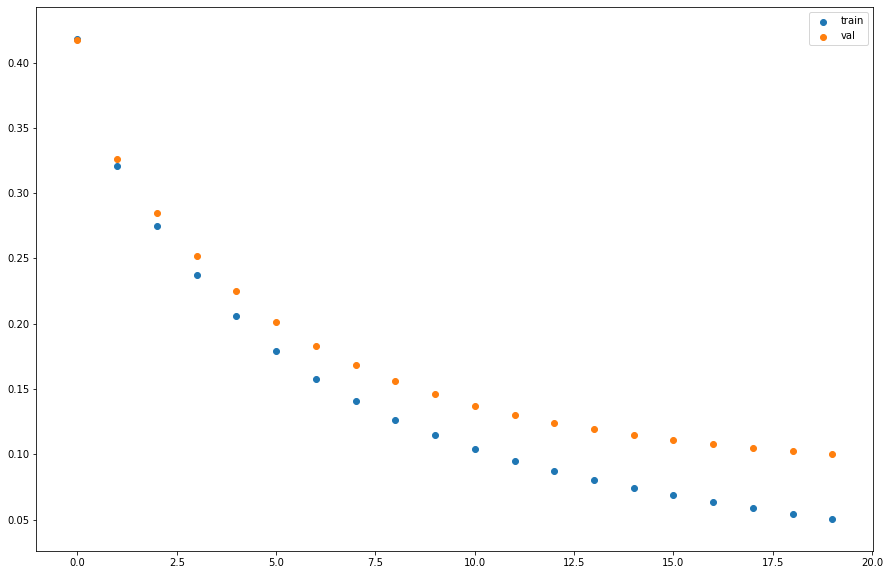

In [332]:
import matplotlib.pyplot as plt
x=list(range(ssn_val.epoch))
plt.figure(figsize=(15,10))
plt.scatter(x,ssn_val.cost, label='train')
plt.scatter(x, ssn_val.cost_val, label='val')
plt.legend()
plt.show()